In [1]:
import pandas as pd

from math import sqrt

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [4]:
# build interactome network
interactome_df = pd.read_csv('./data/Interactome_human.tsv', sep='\t', header=None)

G = nx.from_pandas_edgelist(interactome_df, 0, 1, edge_attr=True)
G.number_of_nodes(), G.number_of_edges()

(14465, 92064)

In [5]:
# get MMAF candidate genes list
candidates_MMAF = pd.read_pickle("./data/candidateGenesList_MMAF.p")
candidates_MMAF = [c for c in candidates_MMAF if c in G.nodes()]
len(candidates_MMAF)

41

In [39]:
# get non candidates for harmonic centrality
nonCandidates_MMAF = [n for n in list(G.nodes) if n not in candidates_MMAF]

### Calculate KC for every node

In [2]:
def candidates_in_neighbourhood(G, candidates, node):
    sub_G = G.subgraph([n for n in G.neighbors(node)])
    candidates_in_neighbourhood = [x for x in [n for n in sub_G] if x in candidates]
    if candidates_in_neighbourhood:
        return candidates_in_neighbourhood
    else:
        return []

In [3]:
# modified version of eigenvector centrality that takes the number of candidates in the neighbourhood into account

def katz_centrality(G, alpha=1, beta=1, max_iter=100, tol=1.0e-6, nstart=None, 
                           weight='weight'): 
    """
    Parameters 
    ---------- 
    G : graph 
      A networkx graph 
  
    max_iter : integer, optional 
      Maximum number of iterations in power method. 
  
    tol : float, optional 
      Error tolerance used to check convergence in power method iteration. 
  
    nstart : dictionary, optional 
      Starting value of eigenvector iteration for each node. 
  
    weight : None or string, optional 
      If None, all edge weights are considered equal. 
      Otherwise holds the name of the edge attribute used as weight.
    """
    if type(G) == nx.MultiGraph or type(G) == nx.MultiDiGraph: 
        raise nx.NetworkXException("Not defined for multigraphs.") 
  
    if len(G) == 0: 
        raise nx.NetworkXException("Empty graph.") 
  
    if nstart is None: 
        # choose starting vector with entries of 1/len(G) 
        x = dict([(n, 1.0/len(G.nodes())) for n in G.nodes()]) 
    else: 
        x = nstart 

    nnodes = G.number_of_nodes() 
  
    # make up to max_iter iterations 
    for i in range(max_iter): 
        xlast = x 
        x = dict.fromkeys(xlast, 0)
  
        # do the multiplication y^T = x^T A 
        for n in x.keys(): 
            for nbr in G[n]: 
                x[nbr] += xlast[n] * G[n][nbr].get(weight, 1)

        # apply alpha and beta
        for n in x:
            x[n] = alpha * x[n] + beta[n]
            
        # normalize vector 
        try: 
            s = 1.0/sqrt(sum(v**2 for v in x.values())) # this should never be zero
        except ZeroDivisionError: 
            s = 1.0

        for n in x: 
            x[n] *= s 
            
        # check convergence 
        err = sum([abs(x[n]-xlast[n]) for n in x]) 
        if err < nnodes*tol: 
            return x 
        
    raise nx.NetworkXError("""eigenvector_centrality(): 
power iteration failed to converge in %d iterations."%(i+1))""") 

In [7]:
# set parameters alpha and beta
alpha = 0.5
beta = 0.5

In [8]:
# first calculate KC for every node in interactome
beta_dict = dict([(n, beta*int(n in candidates_MMAF)) for n in G])

res_KC = katz_centrality(G, alpha=alpha, beta=beta_dict)
res_KC_sorted = dict(sorted(res_KC.items(), key=lambda v: v[1], reverse=True))

# get more info about each node
dict_KC = {}

for n, kc in res_KC_sorted.items():
    dict_KC[n] = (kc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF, n)), (n in candidates_MMAF))

df_KC = pd.DataFrame.from_dict(dict_KC, orient='index', columns=['KC', 'degree', 'candidates in N', 'isCandidate'])
df_KC = df_KC.sort_values(by='KC', ascending=False)

In [9]:
df_KC

,KC,degree,candidates in N,isCandidate
ENSG00000171135,1.091872e-01,103,0,False
ENSG00000168958,1.063078e-01,97,0,False
ENSG00000166257,1.024413e-01,99,0,False
ENSG00000141699,1.012126e-01,102,0,False
ENSG00000126262,9.996390e-02,101,0,False
...,...,...,...,...
ENSG00000080007,5.661493e-112,1,0,False
ENSG00000184735,5.661493e-112,1,0,False
ENSG00000198520,5.661493e-112,1,0,False
ENSG00000183044,5.661493e-112,1,0,False


### Calculate DC for every node

In [30]:
res_DC = nx.degree_centrality(G)
res_DC_sorted = dict(sorted(res_DC.items(), key=lambda v: v[1], reverse=True))

# get more info about each node
dict_DC = {}

for n, dc in res_DC_sorted.items():
    dict_DC[n] = (dc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF, n)), (n in candidates_MMAF))

df_DC = pd.DataFrame.from_dict(dict_DC, orient='index', columns=['DC', 'degree', 'candidates in N', 'isCandidate'])
df_DC = df_DC.sort_values(by='DC', ascending=False)

In [31]:
df_DC

,DC,degree,candidates in N,isCandidate
ENSG00000121634,0.008089,117,0,False
ENSG00000197860,0.007812,113,0,False
ENSG00000170509,0.007605,110,0,False
ENSG00000166946,0.007467,108,2,False
ENSG00000062725,0.007467,108,0,False
...,...,...,...,...
ENSG00000146090,0.000069,1,0,False
ENSG00000173706,0.000069,1,0,False
ENSG00000119004,0.000069,1,0,False
ENSG00000161999,0.000069,1,0,False


### Calculate EV for every node

In [34]:
res_EVC = nx.eigenvector_centrality_numpy(G)
res_EVC_sorted = dict(sorted(res_EVC.items(), key=lambda v: v[1], reverse=True))

# get more info about each node
dict_EVC = {}

for n, evc in res_EVC_sorted.items():
    dict_EVC[n] = (evc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF, n)), (n in candidates_MMAF))

df_EVC = pd.DataFrame.from_dict(dict_EVC, orient='index', columns=['EVC', 'degree', 'candidates in N', 'isCandidate'])
df_EVC = df_EVC.sort_values(by='EVC', ascending=False)

### Calculate HC for every node

In [40]:
res_HC = nx.harmonic_centrality(G, nbunch=nonCandidates_MMAF, sources=candidates_MMAF)
res_HC_sorted = dict(sorted(res_HC.items(), key=lambda v: v[1], reverse=True))

# get more info about each node
dict_HC = {}

for n, hc in res_HC_sorted.items():
    dict_HC[n] = (hc, G.degree(n), len(candidates_in_neighbourhood(G, candidates_MMAF, n)), (n in candidates_MMAF))

df_HC = pd.DataFrame.from_dict(dict_HC, orient='index', columns=['HC', 'degree', 'candidates in N', 'isCandidate'])
df_HC = df_HC.sort_values(by='HC', ascending=False)

### Plot all centrality measures

/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/kubicaj/python_venvs/pyEnv_PPI/lib64/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/

<Axes: ylabel='HC'>

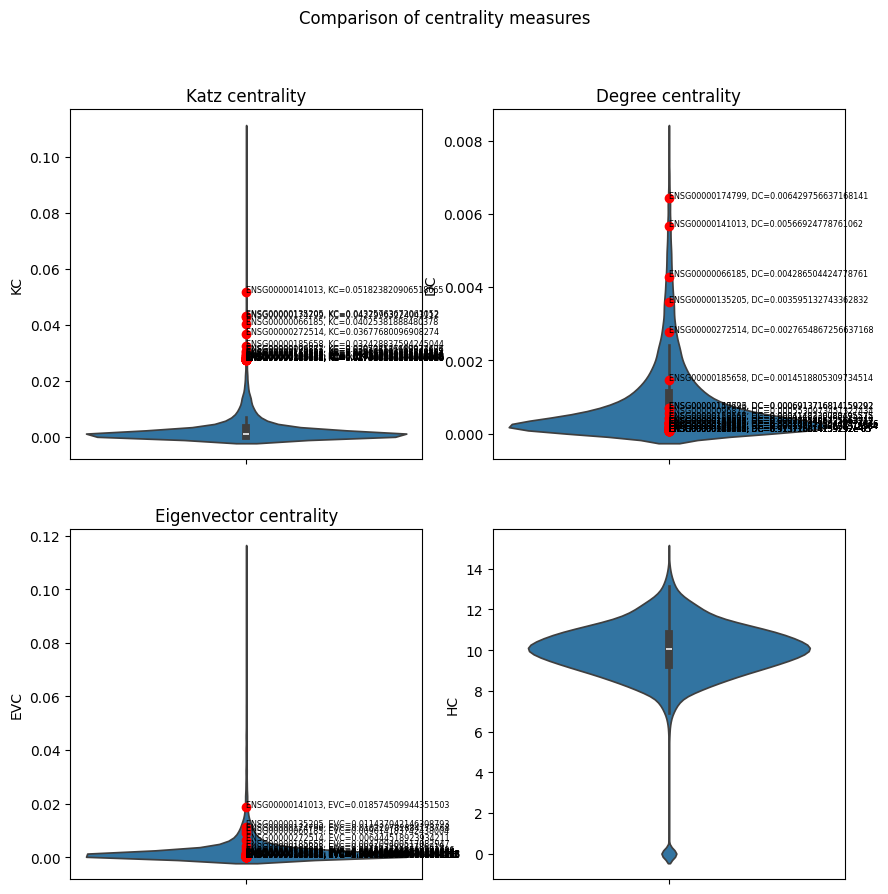

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle("Comparison of centrality measures")

# plot KC distribution
sns.violinplot(data=df_KC['KC'], ax=ax[0, 0])

# plot KC for each candidate
for candidate in candidates_MMAF:
    # get KC
    KC = df_KC.loc[candidate, 'KC']
    ax[0, 0].set_title("Katz centrality")
    ax[0, 0].plot(KC, 'or')
    ax[0, 0].text(0, KC, s=f"{candidate}, KC={KC}", fontsize='xx-small')


# plot DC distribution
sns.violinplot(data=df_DC['DC'], ax=ax[0, 1])

# plot DC for each candidate
for candidate in candidates_MMAF:
    # get DC
    DC = df_DC.loc[candidate, 'DC']
    ax[0, 1].set_title("Degree centrality")
    ax[0, 1].plot(DC, 'or')
    ax[0, 1].text(0, DC, s=f"{candidate}, DC={DC}", fontsize='xx-small')


# plot EVC distribution
sns.violinplot(data=df_EVC['EVC'], ax=ax[1, 0])

# plot EVC for each candidate
for candidate in candidates_MMAF:
    # get DC
    EVC = df_EVC.loc[candidate, 'EVC']
    ax[1, 0].set_title("Eigenvector centrality")
    ax[1, 0].plot(EVC, 'or')
    ax[1, 0].text(0, EVC, s=f"{candidate}, EVC={EVC}", fontsize='xx-small')


# plot HC distribution
sns.violinplot(data=df_HC['HC'], ax=ax[1, 1])

# # plot HC for each candidate
# for candidate in candidates_MMAF:
#     # get DC
#     HC = df_HC.loc[candidate, 'HC']
#     ax[1, 1].set_title("Harmonic centrality")
#     ax[1, 1].plot(HC, 'or')
#     ax[1, 1].text(0, HC, s=f"{candidate}, HC={HC}", fontsize='xx-small')